In [22]:
import pandas as pd
import numpy as np
import os
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from scipy import ndimage
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.colors import ListedColormap

from torchvision import datasets, transforms, models
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

# 1. Image data EDA and pre-processing

In [2]:
TRAIN_PATH = '/Volumes/Yuchen_Drive/Image_nuclei/data-science-bowl-2018/stage1_train'
TEST_PATH = '/Volumes/Yuchen_Drive/Image_nuclei/data-science-bowl-2018/stage1_test'
BASE_DIR = '/Volumes/Yuchen_Drive/Image_nuclei/data-science-bowl-2018'

In [5]:
train_images = glob(os.path.join(TRAIN_PATH, '*/*/*.png'))
print('Total number of files (images + masks) in training dataset: {}'.format(len(train_images)))
test_images = glob(os.path.join(TEST_PATH, '*/*/*.png'))
print('Total number of files (images) in test dataset: {}'.format(len(test_images)))

Total number of files (images + masks) in training dataset: 30131
Total number of files (images) in test dataset: 65


Here is the directory structure of the image and mask files:

<img src="images/Image1_directory_structure.png" width=600px>

For images in the train folder, each image file has its corresponding multiple mask files. For images in the test folder, we need to create an algorithm to detect the nuclei and present as masks.

## 1.1 Load image and mask files
<br>Create file `train_df` that contains the following information:
<br>(each row corresponds to each image or mask file)
* `img_path`: file path of the file (both image and mask files)
* `img_id`: id of the image
* `img_type`: type of the file (image or mask)

In [6]:
train_df = pd.DataFrame({'img_path': train_images})
img_id = lambda x:x.split('/')[-3]
img_type = lambda x:x.split('/')[-2]
train_df['img_id'] = train_df['img_path'].map(img_id)
train_df['img_type'] = train_df['img_path'].map(img_type)
print('image file size: {}'.format(train_df.shape))

image file size: (30131, 3)


In [7]:
train_df.head()

,img_path,img_id,img_type
0,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,00071198d059ba7f5914a526d124d28e6d010c92466da2...,images
1,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,00071198d059ba7f5914a526d124d28e6d010c92466da2...,masks
2,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,00071198d059ba7f5914a526d124d28e6d010c92466da2...,masks
3,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,00071198d059ba7f5914a526d124d28e6d010c92466da2...,masks
4,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,00071198d059ba7f5914a526d124d28e6d010c92466da2...,masks


<br>Create file `train_img_df` that contains the following information:
<br>(each row corresponds to one image file)
* `images`: file path of each image file
* `img_id`: id of the image
* `masks`: file path of the masks corresponding to the image
* `images_px`: numpy array of pixels in the image file
* `masks_px`: numpy array of combined mask files correponding to the image
* `img_height`: height of the image
* `img_width`: width of the image
* `img_shape`: Height x Width x Channel
* `Red`: mean pixel value in 'red' channel
* `Green`: mean pixel value in 'green' channel
* `Blue`: mean pixel value in 'blue' channel
* `Gray`: mean pixel value

In [8]:
train_rows = []
for n_group, n_rows in train_df.groupby(['img_id']):
    c_row = {'img_id': n_group}
    c_row['images'] = n_rows.query('img_type == "images"')['img_path'].item()
    c_row['masks'] = n_rows.query('img_type == "masks"')['img_path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

In [12]:
def img_stack(in_img):
    return imread(in_img)
# def mask_stack(in_img_list):
#     return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
def mask_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)
def img_height(in_img):
    return imread(in_img).shape[0]
def img_width(in_img):
    return imread(in_img).shape[1]
def img_shape(in_img):
    return imread(in_img).shape

train_img_df['images_px'] = train_img_df['images'].map(img_stack).map(lambda x:x[:,:,:3])
train_img_df['masks_px'] = train_img_df['masks'].map(mask_stack).map(lambda x:x.astype(int))
train_img_df['img_height'] = train_img_df['images'].map(img_height)
train_img_df['img_width'] = train_img_df['images'].map(img_width)
train_img_df['img_shape'] = train_img_df['images'].map(img_shape)

train_img_df['Red'] = train_img_df['images_px'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images_px'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images_px'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images_px'].map(lambda x: np.mean(x))

In [14]:
train_img_df.head()

,images,img_id,masks,images_px,masks_px,img_height,img_width,img_shape,Red,Green,Blue,Gray
0,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,00071198d059ba7f5914a526d124d28e6d010c92466da2...,[/Volumes/Yuchen_Drive/Image_nuclei/data-scien...,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [5, 5, 5], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",256,256,"(256, 256, 4)",6.142227,6.142227,6.142227,6.142227
1,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,003cee89357d9fe13516167fd67b609a164651b2193458...,[/Volumes/Yuchen_Drive/Image_nuclei/data-scien...,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [4, 4, 4], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",256,256,"(256, 256, 4)",9.018600,9.018600,9.018600,9.018600
2,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,[/Volumes/Yuchen_Drive/Image_nuclei/data-scien...,"[[[130, 62, 165], [126, 56, 162], [121, 55, 16...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",256,320,"(256, 320, 4)",177.304773,154.222961,193.024976,174.850903
3,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,[/Volumes/Yuchen_Drive/Image_nuclei/data-scien...,"[[[179, 159, 195], [182, 170, 200], [185, 181,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",256,320,"(256, 320, 4)",179.223376,169.042139,204.672217,184.312577
4,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,[/Volumes/Yuchen_Drive/Image_nuclei/data-scien...,"[[[173, 157, 195], [174, 156, 194], [174, 152,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",256,320,"(256, 320, 4)",175.121521,154.262097,200.588892,176.657503


In [84]:
# train_img_df.to_csv('models/Image_nuclei_detection_train_img_df.csv', index = False)

## 1.2 Image and mask files EDA

### 1.2.1 Check image file size

In [16]:
print('Total number of images in training dataset: {}'.format(train_img_df.shape[0]))

Total number of images in training dataset: 670


In [15]:
train_img_df.img_shape.value_counts()

(256, 256, 4)      334
(256, 320, 4)      112
(520, 696, 4)       92
(360, 360, 4)       91
(1024, 1024, 4)     16
(512, 640, 4)       13
(603, 1272, 4)       6
(260, 347, 4)        5
(1040, 1388, 4)      1
Name: img_shape, dtype: int64

The training dataset contains images of variable sizes.

### 1.2.2 Check pixel intensity

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


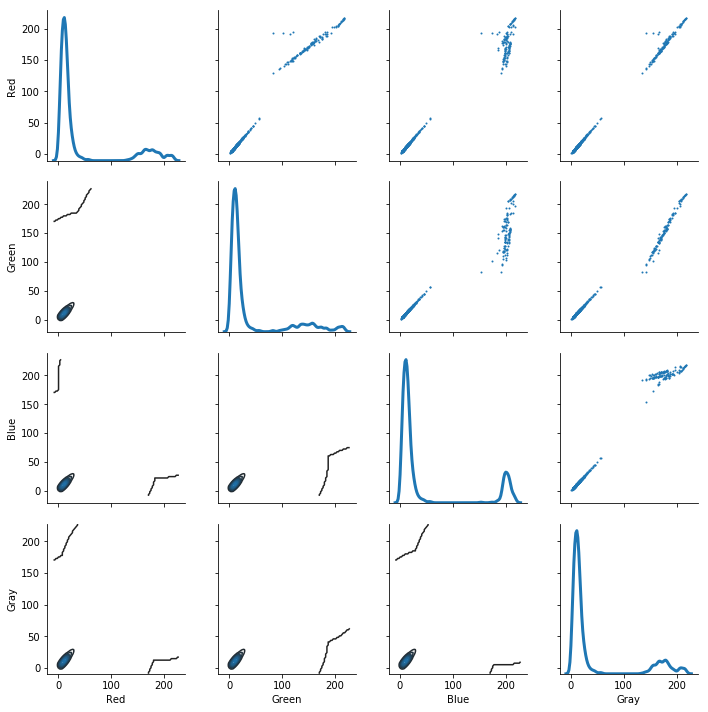

In [23]:
g = sns.PairGrid(train_img_df[['Red', 'Green', 'Blue', 'Gray']], diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, s = 1)
g.map_diag(sns.kdeplot, lw=3)
# sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

The majority of images have a low average pixel intensity. For these images, pixel intensity in each channel (red, green, blue) show strong correlation with each other.

A small percentage of images have high pixel intensity especially for the blue channel.

### 1.2.3 Visualize images and masks

In [ ]:
from skimage.color import rgb2gray

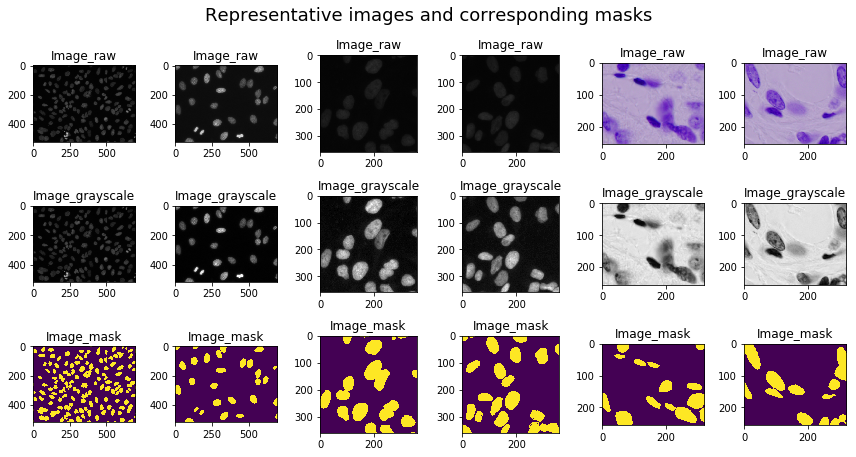

In [26]:
n_img = 6
fig, ax = plt.subplots(3,n_img, figsize=(12,6))
for (_, c_row), (img_raw, img_gray, img_mask) in zip(train_img_df.sample(n_img).iterrows(), ax.T):
    img_raw.imshow(c_row['images_px'])
    img_raw.set_title('Image_raw')
    
    img_gray.imshow(rgb2gray(c_row['images_px']), cmap='gray')
    img_gray.set_title('Image_grayscale')
    
    img_mask.imshow(c_row['masks_px'])
    img_mask.set_title('Image_mask')
    
plt.suptitle('Representative images and corresponding masks', y = 1.05, fontsize=18)
plt.tight_layout()

### Short overview:
1. There are 670 images in the `train` folder. Each image has multiple masks with each corresponding to a nucleus.
2. Images have variable sizes.
3. There are 65 images in the `test` folder.

# 2. Build UNet model and train images

## 2.1 Build Dataset_train

In [27]:
from torch.utils.data import Dataset
class Dataset_train(Dataset):
    def __init__(self, data, img_transform, mask_transform):
        self.images = data
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
    def __getitem__(self, index):
        data = self.images.iloc[index,:]
        img = data['images_px']
        mask = data['masks_px']
        img = self.img_transform(np.uint8(img))
        mask = self.mask_transform(np.uint8(mask))       
        img_id = data['img_id']

        return img, mask, img_id

    def __len__(self):
        return len(self.images)

In [28]:
IMG_SIZE=128
import PIL
img_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE,IMG_SIZE), interpolation=PIL.Image.NEAREST),
    transforms.ToTensor()
])

## 2.2 Split images in train folder to training and validation datasets

In [29]:
total_num = train_img_df.shape[0]
split1 = int(total_num*0.8)
indices = np.arange(total_num)

np.random.seed(123)
np.random.shuffle(indices)
train_idx, val_idx = indices[:split1], indices[split1:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

## 2.3 Build train_loader and val_loader

In [30]:
BATCH_SIZE = 32
train_data = Dataset_train(train_img_df,img_transforms,mask_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, sampler = val_sampler)
print('Number of images in training dataset: {}'.format(len(train_loader.sampler)))
print('Number of images in validation dataset: {}'.format(len(val_loader.sampler)))

Number of images in training dataset: 536
Number of images in validation dataset: 134


## 2.4 UNet

<img src="images/u-net-architecture.png" width=600px>
<br>reference:

https://arxiv.org/pdf/1505.04597.pdf

https://github.com/milesial/Pytorch-UNet/tree/master/unet

In [32]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x
    

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.nn.functional.sigmoid(x)
        return x

## 2.5 Loss function -- soft dice loss

In [33]:
## https://www.jeremyjordan.me/semantic-segmentation/
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

## 2.6 Training

In [34]:
def train_unet(n_epochs, train_loader, val_loader, model, optimizer, device, n_class, save_path):
    '''the train function will perform both forward and backpropagation on training and validation datasets.
    Output: trained model with the lowest val_loss and dataframe containing train_loss and val_loss for each epoch'''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        val_loss = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for images, labels, _ in train_loader:
            optimizer.zero_grad()
            images = torch.autograd.Variable(images).to(device)
            labels = torch.autograd.Variable(labels).to(device)
            output = model(images)
            ## Compute dice_loss
            loss = soft_dice_loss(output, labels)
            loss.backward()
            optimizer.step()
            ## Update loss and acc values for the training process
            train_loss += loss.item()*images.shape[0]
            
        # Validation
        else:
            # turn off gradients
            with torch.no_grad():
                # set model to evaluation mode
                model.eval()
                for images, labels, _ in val_loader:
                    images = torch.autograd.Variable(images).to(device)
                    labels = torch.autograd.Variable(labels).to(device)
                    output = model(images)
                    ## Compute dice_loss
                    loss = soft_dice_loss(output, labels)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*images.shape[0]

                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)

                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)))
                
                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss

    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_class=1

In [37]:
model = UNet(3, 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
n_epochs = 20
save_path = 'models/Image_nuclei_segmentation_unet3_epoch50_lr3.pth'
model, epoch_df = train_unet(n_epochs, train_loader, val_loader, model, optimizer, device, n_class, save_path)

In [ ]:
epoch_df.to_csv('models/Image_nuclei_segmentation_unet3_epoch50_lr3.csv', index = False)

# 3. Model evaluation

## 3.1 Visualize the loss function output

In [39]:
epoch_df = pd.read_csv('models/Image_nuclei_segmentation_unet3_epoch50_lr3.csv')

Text(0.5, 1.0, 'Training and Validation Loss')

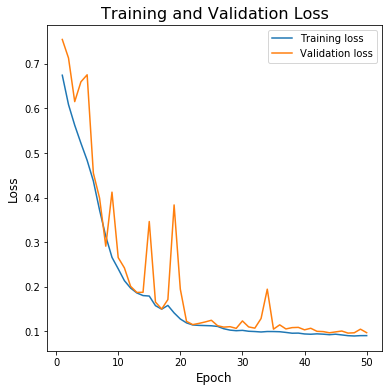

In [40]:
plt.figure(figsize=(6,6))
plt.subplot(1,1,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

## 3.2 Load the trained model

In [41]:
model = UNet(3,1)
if device.type == 'cpu':
    state_dict = torch.load('models/Image_nuclei_segmentation_unet3_epoch50_lr3.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Image_nuclei_segmentation_unet3_epoch50_lr3.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

## 3.3 Visualize prediction result in training dataset

In [87]:
images, masks, img_id = next(iter(train_loader))
with torch.no_grad():
        model.eval()
        output = model(images)

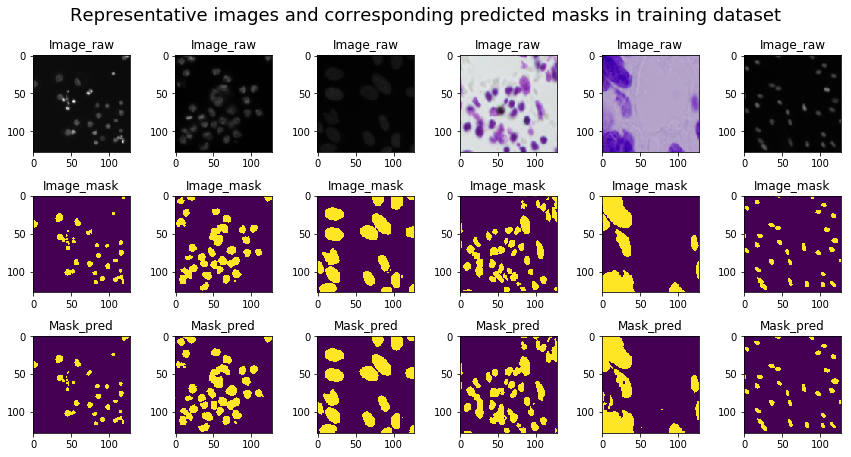

In [88]:
fig, ax = plt.subplots(3,6,figsize=(12,6))
for i in np.arange(6):
    ax[0,i].imshow(images[i].permute(1, 2, 0)*0.5+0.5)
    ax[0,i].set_title('Image_raw')
    ax[1,i].imshow(np.squeeze(masks[i]))
    ax[1,i].set_title('Image_mask')
    pred = np.squeeze(output[i])
    pred = (pred>0.5).numpy().astype(np.uint8)
    ax[2,i].imshow(pred)
    ax[2,i].set_title('Mask_pred')
plt.suptitle('Representative images and corresponding predicted masks in training dataset', y = 1.05, fontsize=18)
plt.tight_layout()

## 3.4 Load images from test dataset

In [46]:
TEST_PATH = '/Volumes/Yuchen_Drive/Image_nuclei/data-science-bowl-2018/stage1_test'
test_images = glob(os.path.join(TEST_PATH, '*/*/*.png'))
print('Total number of test files (images + masks): {}'.format(len(test_images)))

Total number of test files (images + masks): 65


In [50]:
test_img_df = pd.DataFrame({'images': test_images})
img_id = lambda x:x.split('/')[-3]
test_img_df['img_id'] = test_img_df['images'].map(img_id)

In [51]:
def img_stack(in_img):
    return imread(in_img)
# def mask_stack(in_img_list):
#     return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
def mask_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)
def img_height(in_img):
    return imread(in_img).shape[0]
def img_width(in_img):
    return imread(in_img).shape[1]
def img_shape(in_img):
    return imread(in_img).shape

test_img_df['images_px'] = test_img_df['images'].map(img_stack).map(lambda x:x[:,:,:3])
test_img_df['img_height'] = test_img_df['images'].map(img_height)
test_img_df['img_width'] = test_img_df['images'].map(img_width)
test_img_df['img_shape'] = test_img_df['images'].map(img_shape)

In [52]:
test_img_df.head()

,images,img_id,images_px,img_height,img_width,img_shape
0,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[[[3, 3, 3], [3, 3, 3], [4, 4, 4], [3, 3, 3], ...",256,256,"(256, 256, 4)"
1,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,"[[[20, 20, 20], [18, 18, 18], [18, 18, 18], [1...",519,253,"(519, 253, 3)"
2,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,"[[[18, 18, 18], [18, 18, 18], [20, 20, 20], [2...",256,256,"(256, 256, 3)"
3,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,"[[[13, 13, 13], [13, 13, 13], [13, 13, 13], [1...",256,256,"(256, 256, 4)"
4,/Volumes/Yuchen_Drive/Image_nuclei/data-scienc...,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,"[[[14, 14, 14], [14, 14, 14], [14, 14, 14], [1...",256,256,"(256, 256, 4)"


In [83]:
# test_img_df.to_csv('models/Image_nuclei_detection_test_img_df.csv', index = False)

In [53]:
from torch.utils.data import Dataset
class Dataset_test(Dataset):
    def __init__(self, data, img_transform):
        self.images = data
        self.img_transform = img_transform
        
    def __getitem__(self, index):
        data = self.images.iloc[index,:]
        img = data['images_px']
        img = self.img_transform(np.uint8(img))
        img_id = data['img_id']

        return img, img_id

    def __len__(self):
        return len(self.images)

In [54]:
IMG_SIZE=128
import PIL
img_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [55]:
test_data = Dataset_test(test_img_df,img_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE)
print('Number of images in test dataset: {}'.format(len(test_loader.sampler)))

Number of images in test dataset: 65


## 3.5 Predict masks for images in test dataset

In [56]:
test_id = np.array([])
test_mask = []
with torch.no_grad():
    model.eval()
    for images, img_id in test_loader:
        images = torch.autograd.Variable(images).to(device)
        output = model(images)
        test_mask.append(output.numpy())
        test_id = np.append(test_id, np.array(img_id))
test_mask = np.concatenate(test_mask)

In [57]:
pred_df = pd.DataFrame()
for i in np.arange(len(test_loader.sampler)):
    s = pd.Series({'ImageId': test_id[i], 'pred_mask': test_mask[i]})
    pred_df = pred_df.append(s, ignore_index=True)

In [58]:
pred_df.head()

,ImageId,pred_mask
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[[[0.00021982737, 0.00013689151, 7.0738904e-05..."
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,"[[[0.000488364, 0.00023196668, 9.620089e-05, 0..."
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,"[[[0.00031050894, 0.00035271354, 0.0009686785,..."
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,"[[[0.00018639452, 0.00011838327, 6.5788e-05, 6..."
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,"[[[0.00019441103, 0.000116098876, 5.89847e-05,..."


In [82]:
# pred_df.to_csv('models/Image_nuclei_detection_pred_df.csv', index = False)

## 3.6 Visualize prediction result in test dataset

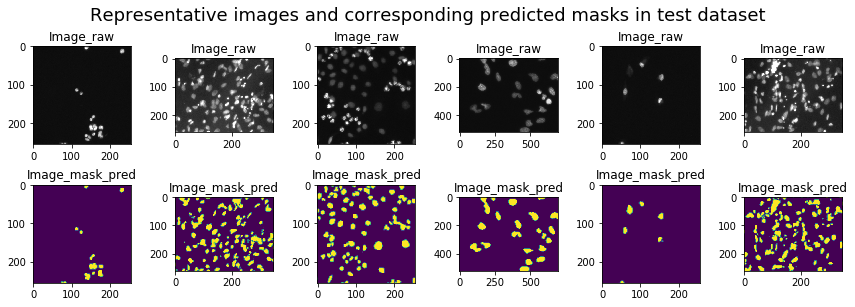

In [59]:
n_img = 6
img_idx = np.random.choice(65, n_img, replace=False)
fig, ax = plt.subplots(2,n_img, figsize=(12,4))

for i in np.arange(n_img):
    idx = img_idx[i]
    img_id = pred_df.iloc[idx,:]['ImageId']
    img_mask = pred_df.iloc[idx,:]['pred_mask'].squeeze()
    img_raw = test_img_df[test_img_df.img_id == img_id]['images_px']
    img_H = test_img_df[test_img_df.img_id == img_id]['img_height'].item()
    img_W = test_img_df[test_img_df.img_id == img_id]['img_width'].item()
    
    test_view_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_H,img_W)),
        transforms.ToTensor()])
    
    img_mask = test_view_transforms(img_mask)
    
    plt.subplot(2,n_img,i+1)
    plt.imshow(img_raw.item())
    plt.title('Image_raw')
    
    plt.subplot(2,n_img,i+7)
    plt.imshow(np.squeeze(img_mask))
    plt.title('Image_mask_pred')

plt.suptitle('Representative images and corresponding predicted masks in test dataset', y = 1.05, fontsize=18)
plt.tight_layout()

# 4. Encode predicted masks

Here based on the predicted masks, the following tasks are performed:
<br>1.`test_view_transforms`: transform predicted masks and resize to the original image size
<br>2.`threshold_otsu` -- **Removing background**: `Otsu` method models the image as a bimodal distribution and finds the optimal separation value. It assume that there are two classes in the image: objects of interest and the background
<br>3.`scipy.ndimage.label` -- **Label individual cells** (`cell_num1`): label features in an array based on a structuring element that defines feature connections
<br>default:
<br>`[[0,1,0],
[1,1,1],
[0,1,0]]`
<br>4.Remove small cells: np.product(cell.shape) < 100
<br>5.Re-calculate cell number (`cell_num2`)
<br>6.`rle_encoding`: encode each mask into a "run line encoded" string

<br>The final encoded prediction result is saved in file `img_test_encode_df`. Each line corresponds to an individual valid mask that passes step 4.

## 4.1 Generate dataframe containing encoded masks and cell number

In [61]:
## Run length Encoding from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [60]:
def prediction_encoding(test_loader, pred_df, test_img_df):
    img_test_encode_df = pd.DataFrame()
    for i in np.arange(len(test_loader.sampler)):
        img_id = pred_df.iloc[i,:]['ImageId']
        img_mask = pred_df.iloc[i,:]['pred_mask'].squeeze()
        img_raw = test_img_df[test_img_df.img_id == img_id]['images_px'].item()
        img_H = test_img_df[test_img_df.img_id == img_id]['img_height'].item()
        img_W = test_img_df[test_img_df.img_id == img_id]['img_width'].item()
        test_view_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_H,img_W)),
            transforms.ToTensor()])

        img_mask = test_view_transforms(img_mask).numpy().squeeze()

        thresh = threshold_otsu(img_mask)
        mask = np.where(img_mask > thresh, 1, 0)
        if np.sum(mask==0) < np.sum(mask==1):
            mask = np.where(mask, 0, 1)

        labels, nlabels = ndimage.label(mask)
        
        for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
            cell = img_mask[label_coords]
            if np.product(cell.shape) < 100:
                mask = np.where(labels == label_ind+1, 0, mask)

        labels_2, nlabels_2 = ndimage.label(mask)
        
        for label_num in range(1,nlabels_2+1):
            label_mask = np.where(labels_2 == label_num, 1, 0)
            rle = rle_encoding(label_mask)
            s = {'img_id': img_id, 'cell_num1':nlabels, 'cell_num2':nlabels_2, 'mask_num':label_num, 'EncodedPixels':rle}
            img_test_encode_df = img_test_encode_df.append(s, ignore_index=True)
    img_test_encode_df['cell_num1'] = img_test_encode_df.cell_num1.astype(np.int16)
    img_test_encode_df['cell_num2'] = img_test_encode_df.cell_num2.astype(np.int16)
    img_test_encode_df['mask_num'] = img_test_encode_df.mask_num.astype(np.int16)
    return img_test_encode_df

In [62]:
img_test_encode_df = prediction_encoding(test_loader, pred_df, test_img_df)

In [64]:
img_test_encode_df.head()

,EncodedPixels,cell_num1,cell_num2,img_id,mask_num
0,45103 10 45359 10 45613 14 45869 14 46124 14 4...,8,6,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1
1,50277 10 50533 10 50787 14 51043 14 51297 16 5...,8,6,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,2
2,10891 6 11147 7 11399 12 11655 12 11909 14 121...,8,6,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,3
3,31375 6 31631 6 31883 14 32139 14 32393 16 326...,8,6,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,4
4,50841 6 51097 6 51349 10 51605 10 51859 12 521...,8,6,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,5


In [86]:
# img_test_encode_df.to_csv('models/Image_nuclei_detection_img_test_encode_df.csv', index = False)

## 4.2 Visualize nuclei detection with multi-channel imaging

In [78]:
idx = 0
img_id = pred_df.iloc[idx,:]['ImageId']
img_mask = pred_df.iloc[idx,:]['pred_mask'].squeeze()
img_raw = test_img_df[test_img_df.img_id == img_id]['images_px'].item()
img_H = test_img_df[test_img_df.img_id == img_id]['img_height'].item()
img_W = test_img_df[test_img_df.img_id == img_id]['img_width'].item()
    
test_view_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_H,img_W)),
    transforms.ToTensor()])

img_mask = test_view_transforms(img_mask).numpy().squeeze()

thresh = threshold_otsu(img_mask)
mask = np.where(img_mask > thresh, 1, 0)
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

labels, nlabels = ndimage.label(mask)
print('Number of masks/cells for this image: {}'.format(nlabels))

for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = img_mask[label_coords]
    if np.product(cell.shape) < 100:
        mask = np.where(labels == label_ind+1, 0, mask)

labels_2, nlabels_2 = ndimage.label(mask)
print('Number of masks/cells for this image (after filtering): {}'.format(nlabels_2))

Number of masks/cells for this image: 8
Number of masks/cells for this image (after filtering): 6


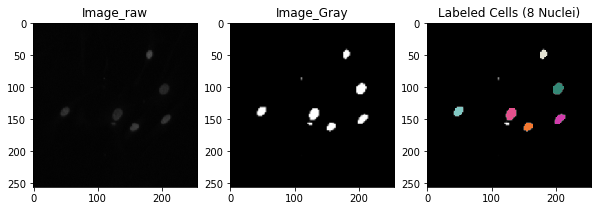

In [79]:
rand_cmap = ListedColormap(np.random.rand(256,3))
labels_for_display = np.where(labels_2 > 0, labels_2, np.nan)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img_raw)
plt.title('Image_raw')
plt.subplot(1,3,2)
plt.imshow(img_mask, cmap='gray')
plt.title('Image_Gray')
plt.subplot(1,3,3)
plt.imshow(img_mask, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

## 4.3 Visualize individual cells

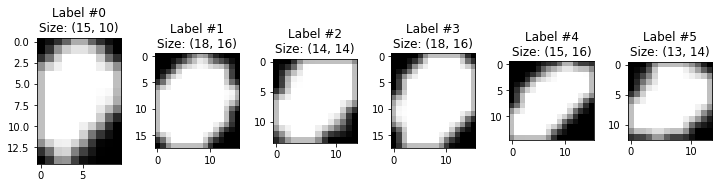

In [81]:
fig, axs = plt.subplots(1,6, figsize=(10,6))
for label_ind, label_coords in enumerate(ndimage.find_objects(labels_2)[0:6]):
    cell = img_mask[label_coords]
    axs[label_ind].imshow(cell, cmap='gray')
    axs[label_ind].set_title('Label #{}\nSize: {}'.format(label_ind, cell.shape))
plt.tight_layout()
plt.show()